首先进行的是文件读取

In [2]:
#加载数据
def load_cifar_batch(file_path):
    import pickle
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

def load_cifar_data(folder_path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    # 加载训练数据 从1-5加载数据
    for i in range(1, 6):
        file_path = folder_path + '/data_batch_' + str(i)
        batch_data = load_cifar_batch(file_path)
        #加载data
        train_data.append(batch_data[b'data'])
        #加载label
        train_labels += batch_data[b'labels']

    # Load testing data
    file_path = folder_path + '/test_batch'
    batch_data = load_cifar_batch(file_path)
    test_data.append(batch_data[b'data'])
    test_labels += batch_data[b'labels']

    return train_data, train_labels, test_data, test_labels


In [3]:
# Specify the folder path where the cifar-10-python folder is located
folder_path = '../cifar-10-python/cifar-10-batches-py'

#训练数据，训练标签，测试数据，测试标签 加载 CIFAR-10 数据
train_data, train_labels, test_data, test_labels = load_cifar_data(folder_path)

In [4]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(5, 50000, 1, 10000)

输出train_data前10张图片

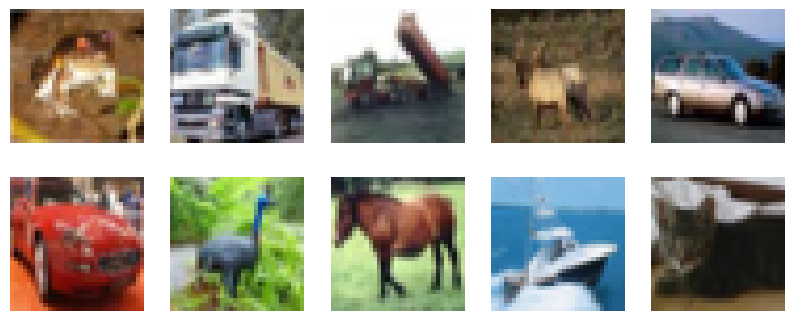

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# 将train_data转换为numpy数组， 形状改变(num_images, 3, 32, 32)
train_data_np = np.array(train_data).reshape(-1, 3, 1024)  # reshape to (num_images, 3, 1024)
#交换第二第三维度
train_data_np = train_data_np.transpose((0, 2, 1))  # transpose to (num_images, 1024, 3)
#改变大小
train_data_np = train_data_np.reshape(-1, 32, 32, 3)  # reshape to (num_images, 32, 32, 3)

#图形（顶级容器），子图（图像中的一个子图） 创建2*5子图网格 
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# 展示前10张图片 enumerate获取索引和元素
for i, ax in enumerate(axes.flat):
    img = train_data_np[i] / 255.0  # normalize to [0, 1] range
    ax.imshow(img)
    #关闭坐标轴
    ax.axis('off')

plt.show()

超参数设置：`batch_size = 128`，`num_epochs = 100`，`lr = 0.1`，`lr_period = 50`，`lr_decay = 0.1`

In [6]:
batch_size = 128
num_epochs = 100
lr = 0.1
lr_period = 50
lr_decay = 0.1
valid_ratio = 0.1

cifar-10数据集比较好的做法是，使用resnet50直接train，150一轮不decay，后几轮再decay

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import resnet50


图像增广，训练集进行增广，测试时标准化执行，先不使用，先把最简单的跑起来试试

In [8]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [9]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

读取数据集

In [10]:
! pip install scikit-learn

In [12]:

import numpy as np
from sklearn.model_selection import train_test_split

# Convert train_data and train_labels to numpy arrays
# train_data_np = np.array(train_data)
train_labels_np = np.array(train_labels)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data_np, train_labels_np, test_size=0.2, random_state=42)


定义模型，使用resnet18。

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。

首先是残差块的实现

In [14]:
from torch.nn import functional as F
#画图表示
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        #初始化
        super().__init__()
        #两个卷积层，内核大小都为3，
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        #输入通道为上一层的输出通道
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:#如果不使用的话，在应用Relu前，将输入添加到输出；如果使用，通过添加1×1卷积来调整通道和分辨率
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        #两个批量归一化层
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

接下来是resnet18网络

这段代码定义了一个深度卷积神经网络，该网络使用了 ResNet（残差网络）的结构。首先，使用 `nn.Sequential` 创建了一个空的神经网络 `net`，然后向其中添加了各种层。

首先，添加了一个卷积层 `nn.Conv2d`，其输入通道数为 `in_channels`，输出通道数为 64，卷积核大小为 3x3，步长为 1，填充为 1。接着，添加了一个批量归一化层 `nn.BatchNorm2d` 和一个 ReLU 激活函数。

然后，使用 [`add_module`](command:_github.copilot.openSymbolInFile?%5B%22..%2F..%2Fsoftware%2Fminiconda%2Fenvs%2Fd2l%2FLib%2Fsite-packages%2Ftorch%2Fnn%2Fmodules%2Fmodule.py%22%2C%22add_module%22%5D "../../software/miniconda/envs/d2l/Lib/site-packages/torch/nn/modules/module.py") 方法向 `net` 中添加了四个残差块 `resnet_block`。每个残差块由多个残差单元组成，每个残差单元包含两个 3x3 的卷积层。第一个残差块的输入和输出通道数都是 64，其余的残差块的输入通道数和上一个残差块的输出通道数相同，输出通道数依次为 128，256，512。除了第一个残差块，其他的残差块在第一个残差单元中都包含一个步长为 2 的 1x1 卷积层，用于将输入数据的高和宽减半。

接着，添加了一个全局平均池化层 `nn.AdaptiveAvgPool2d`，其输出大小为 1x1，用于将每个通道的高和宽都降为 1。

最后，添加了一个全连接层 `fc`，用于将网络的输出从 512 维降到 `num_classes` 维，以进行分类。全连接层由一个 `nn.Flatten` 层和一个 `nn.Linear` 层组成，`nn.Flatten` 层用于将输入数据展平，`nn.Linear` 层用于进行线性变换。

这个网络结构是一个典型的 ResNet 结构，它通过使用残差块来解决深度神经网络中的梯度消失和表示瓶颈问题。

In [15]:
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    Residual(in_channels, out_channels, use_1x1conv=True,
                                 strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc",
                   nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

输出网络结构

In [16]:
def get_net():
    num_classes = 10
    net = resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [18]:
X = torch.rand(size=(1, 3, 224, 224))
testnet=get_net()
for layer in testnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
BatchNorm2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Sequential output shape:	 torch.Size([1, 64, 224, 224])
Sequential output shape:	 torch.Size([1, 128, 112, 112])
Sequential output shape:	 torch.Size([1, 256, 56, 56])
Sequential output shape:	 torch.Size([1, 512, 28, 28])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Sequential output shape:	 torch.Size([1, 10])


接下来定义模型训练函数train：


In [19]:
from d2l import torch as d2l

In [ ]:
#网络、训练迭代器、验证迭代器、训练周期、学习率、权重衰减、设备、学习率周期、学习率衰减
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay):
    #sgd初始化训练器
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    #步进学习率调度器
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    #画图
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    #将网络封装为数据并行模型
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [ ]:
#根据,封装train和valid迭代器

import torch
from torch.utils.data import TensorDataset, DataLoader

# 假设 train_data_np, train_labels_np, X_val, y_val 是已经存在的numpy数组
# 首先，我们需要将numpy数组转换为torch张量
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)

# 然后，我们将张量封装到TensorDataset中
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 最后，我们创建DataLoader
batch_size = 128  # 你可以根据需要调整这个值
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iter = DataLoader(valid_dataset, batch_size=batch_size)



训练模型

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 100, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)